In [659]:
using Zygote, LinearAlgebra, Flux, Statistics, Images, Random, CUDA, Plots, Distributions, StatsAPI, Tables, Impute
ENV["DATADEPS_ALWAYS_ACCEPT"] = true
using MLDatasets, MLUtils, DataFrames, MLJ, OpenML
axis(x) = D -> [D[[k != x ? (:) : i for k in 1:length(size(D))]...] for i in axes(D, x)]
axis(D, x) = axis(x)(D)
# Read in OpenML dataset for benchmarking
begin
    data = OpenML.load(197)
end

data
# Normalize the data
begin
    M = data |> Tables.matrix
    M = M .- mean(M, dims=1)
    M = M ./ std(M, dims=1)
    M = M' |> collect
end

# Setup for training
epochs = 5
batch_size = 128
opt = ADAM(0.01)
loss = Flux.mse

shuffled = M[:, randperm(size(M, 2))]
train_X = shuffled[:, 1:Int(0.8 * size(M, 2) |> round)]
test_X = shuffled[:, Int(0.8 * size(M, 2) |> round):end]

w = size(train_X, 1)
N = size(train_X, 2)
hs = 3

3

In [660]:
function forward(X, Known, regressor, weighter)
    X_known = X .* Known
    M_h = weighter(Known) .* (Known)
    X_hat = regressor(X_known .* M_h)
    X_adj = (X_hat .* (1 .- Known)) .+ X_known
end

forward (generic function with 3 methods)

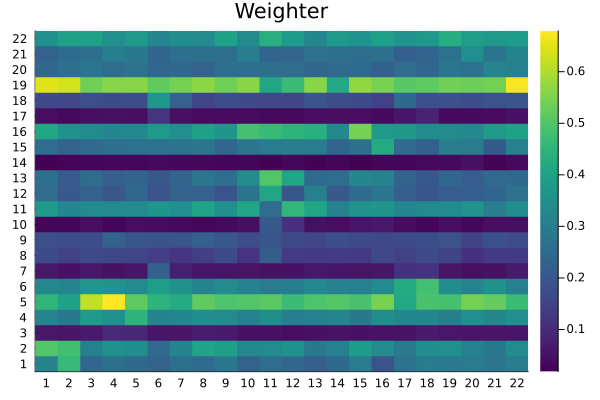

In [661]:
regressor = Chain(Dense(w, w, selu), Dense(w, w, selu)) |> cpu
weighter = Chain(Dense(w, w, selu), Dense(w, w, sigmoid)) |> cpu
full = Chain(regressor, weighter)
p = Flux.params(full)
losses = []
for _ in 1:epochs
    known_mat = rand(Bernoulli(0.5), size(train_X)) .|> Float32
    for i in Iterators.partition(randperm(N), batch_size)
        X = train_X[:, i]
        K = known_mat[:, i]
        train_loss, back = Zygote.pullback(p) do
            loss(forward(X, K, regressor, weighter), X)
        end
        grads = back(one(train_loss))
        push!(losses, train_loss)
        Flux.Optimise.update!(opt, p, grads)
    end
end
feature_cov = ones(22, 22) .- diagm(0 => ones(22))
heatmap(weighter(feature_cov), title="Weighter", color=:viridis, colorbar=true, xticks = (1:22, string.(1:22)), yticks = (1:22, string.(1:22)))

In [671]:
rand(1000)' |> Dense(1, 10, selu)

10×1000 Matrix{Float64}:
 -0.382746   -0.1547     -0.276766   …  -0.175299  -0.238988   -0.0703293
 -0.789245   -0.352178   -0.597987      -0.395614  -0.524872   -0.165843
  0.582599    0.218561    0.406455       0.249243   0.346699    0.0968738
 -0.888563   -0.40808    -0.682302      -0.45722   -0.601745   -0.194222
 -0.858839   -0.390949   -0.656777      -0.438378  -0.578382   -0.185457
 -0.558361   -0.234801   -0.411426   …  -0.265151  -0.357596   -0.108235
 -0.714969   -0.312674   -0.536635      -0.35187   -0.469454   -0.146166
 -0.580586   -0.245449   -0.42888       -0.277046  -0.373094   -0.113356
  0.284042    0.106558    0.198164       0.121517   0.169031    0.0472301
  0.0975285   0.0365876   0.0680416      0.041724   0.0580383   0.0162169

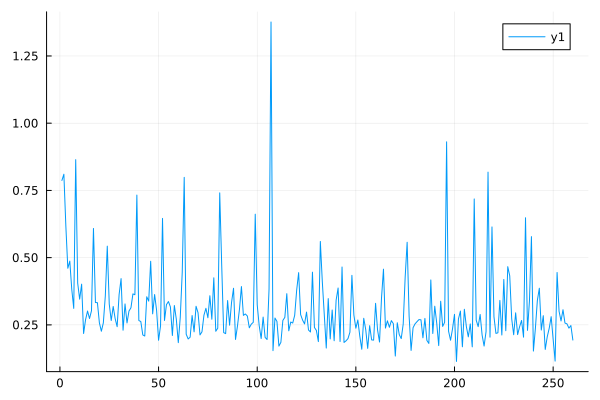

In [662]:
plot(losses)

In [663]:
known_test = rand(Bernoulli(0.8), size(test_X)) .|> Float32
let X = test_X, K = known_test
    (forward(X, K, regressor, weighter) .-  X) .^ 2 |> sum
end

2905.9122924814646

In [664]:
imptest = test_X .* replace(known_test, 0 => missing)
full_test = hcat(train_X, imptest)
knn_res = Impute.knn(full_test)
full = hcat(train_X, test_X)
(knn_res .- full) .^ 2 |> sum

4703.020212058519

In [665]:
svd_res = Impute.svd(full_test)
(svd_res .- full) .^ 2 |> sum

3629.2082541714226

In [666]:
mean_res = Impute.substitute(full_test)
(mean_res .- full) .^ 2 |> sum

6827.35412106684

In [667]:
srs_res = Impute.srs(full_test)
(srs_res .- full) .^ 2 |> sum

11926.745587373352

In [633]:
feature_importance = sum(weighter(known_test) .* (1 .- known_test), dims = 2) |> normalize

22×1 Matrix{Float32}:
 0.14651087
 0.012766671
 0.14854464
 0.25577903
 0.243282
 0.17632452
 0.10594181
 0.06552945
 0.17083079
 0.13907655
 0.35618874
 0.32162768
 0.16381492
 0.060820315
 0.15699576
 0.18729433
 0.13796492
 0.3787472
 0.33098862
 0.12671347
 0.19539273
 0.2995256